# Data Collection: Web-scraping and APIs

This portfolio example showcases data collection skills through web-scraping and APIs, which also includes data cleaning and visualization coding examples. This notebook is divided into three parts, the first two are focused on web-scraping and data vizulaiztion from Wikipedia, whereas the last one deals with time-series data from API.

In [83]:
# Importing relevant libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

pd.core.common.is_list_like = pd.api.types.is_list_like
import datetime
import pandas_datareader.data as web
import quandl

## Part 1. Web-scraping from Wikipedia: Covid-19 testing by country

The data for this part will be collected from the Wikipedia page on [Covid-19 Testing](https://en.wikipedia.org/wiki/COVID-19_testing), followed by data cleaning with regular expressions and data visualization.


In [84]:
url1 = "https://en.wikipedia.org/w/index.php?title=Template:COVID-19_testing_by_country"

In [85]:
session = requests.Session()
response = session.get(url1, timeout = 10)

In [86]:
soup = BeautifulSoup(response.text, 'html.parser')

In [87]:
covid19table = soup.find('table', {'class':"wikitable"})

In [88]:
covid19table = pd.read_html(str(covid19table))
covid19table = pd.DataFrame(covid19table[0])
covid19table.head()

,Country or region,Date[a],Tested,Units[b],Confirmed(cases),"Confirmed /tested,%","Tested /population,%","Confirmed /population,%",Ref.
0,Afghanistan,17 Dec 2020,154767,samples,49621,32.1,0.40,0.13,[1]
1,Albania,18 Feb 2021,428654,samples,96838,22.6,15.0,3.4,[2]
2,Algeria,2 Nov 2020,230553,samples,58574,25.4,0.53,0.13,[3][4]
3,Andorra,23 Feb 2022,300307,samples,37958,12.6,387,49.0,[5]
4,Angola,2 Feb 2021,399228,samples,20981,5.3,1.3,0.067,[6]


In [89]:
# Dropping irrelevant Ref. and Units[b] columns from the dataset
covid19table.drop(['Units[b]','Ref.'], axis=1, inplace = True)

# Dropping the last row from the dataset
covid19table.drop(covid19table.index[172], inplace = True)

# Renaming column names
covid19table.rename(columns={'Country or region': 'COUNTRY', 'Date[a]': 'DATE',
                             'Tested': 'TESTED', 'Confirmed(cases)': 'CONFIRMED',
                             'Confirmed /tested,%': 'CONFIRMED/TESTED(%)',
                             'Tested /population,%': 'TESTED/POPULATION(%)',
                             'Confirmed /population,%': 'CONFIRMED/POPULATION(%)'}, 
                    inplace = True)

covid19table.head()

,COUNTRY,DATE,TESTED,CONFIRMED,CONFIRMED/TESTED(%),TESTED/POPULATION(%),CONFIRMED/POPULATION(%)
0,Afghanistan,17 Dec 2020,154767,49621,32.1,0.40,0.13
1,Albania,18 Feb 2021,428654,96838,22.6,15.0,3.4
2,Algeria,2 Nov 2020,230553,58574,25.4,0.53,0.13
3,Andorra,23 Feb 2022,300307,37958,12.6,387,49.0
4,Angola,2 Feb 2021,399228,20981,5.3,1.3,0.067


**Important remarks:** Testing strategies vary by country and over time, with some countries testing very widely, while others have at times focused narrowly on only testing the seriously ill. The country that tests only people showing symptoms will have a higher figure for `CONFIRMED/TESTED(%)` than the country that also tests others. If two countries are alike in every respect, including which people they test, the one that tests more people will have a higher `CONFIRMED/POPULATION(%)`. Studies have also found that countries that test more, relative to the number of deaths, have lower estimated case fatality rates and younger age distributions of cases.

In [90]:
# Changing data types
covid19table[['TESTED', 'CONFIRMED']] = covid19table[['TESTED', 'CONFIRMED']].astype('int64')
covid19table[['CONFIRMED/TESTED(%)', 'TESTED/POPULATION(%)', 'CONFIRMED/POPULATION(%)']] = covid19table[['CONFIRMED/TESTED(%)', 'TESTED/POPULATION(%)', 'CONFIRMED/POPULATION(%)']].astype('float64')
covid19table["DATE"] = pd.to_datetime(covid19table["DATE"])
covid19table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   COUNTRY                  172 non-null    object        
 1   DATE                     172 non-null    datetime64[ns]
 2   TESTED                   172 non-null    int64         
 3   CONFIRMED                172 non-null    int64         
 4   CONFIRMED/TESTED(%)      172 non-null    float64       
 5   TESTED/POPULATION(%)     172 non-null    float64       
 6   CONFIRMED/POPULATION(%)  172 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 9.5+ KB


In [91]:
print(covid19table['COUNTRY'].unique())

['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'Brunei' 'Bulgaria' 'Burkina Faso' 'Burundi'
 'Cambodia' 'Cameroon' 'Canada' 'Chad' 'Chile' 'China[c]' 'Colombia'
 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus[d]' 'Czechia' 'Denmark[e]'
 'Djibouti' 'Dominica' 'Dominican Republic' 'DR Congo' 'Ecuador' 'Egypt'
 'El Salvador' 'Equatorial Guinea' 'Estonia' 'Eswatini' 'Ethiopia'
 'Faroe Islands' 'Fiji' 'Finland' 'France[f][g]' 'Gabon' 'Gambia'
 'Georgia[h]' 'Germany' 'Ghana' 'Greece' 'Greenland' 'Grenada' 'Guatemala'
 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti' 'Honduras' 'Hungary' 'Iceland'
 'India' 'Indonesia' 'Iran' 'Iraq' 'Ireland' 'Israel' 'Italy'
 'Ivory Coast' 'Jamaica' 'Japan' 'Jordan' 'Kazakhstan' 'Kenya' 'Kosovo'
 'Kuwait' 'Kyrgyzstan' 'Laos' 'Latvia' 'Lebanon' 

In [92]:
# Cleaning data in the COUNTRY column
covid19table['COUNTRY'] = covid19table['COUNTRY'].replace(to_replace = '\[[][\w][]]', value = '', regex = True)
print(covid19table['COUNTRY'].unique())

['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'Brunei' 'Bulgaria' 'Burkina Faso' 'Burundi'
 'Cambodia' 'Cameroon' 'Canada' 'Chad' 'Chile' 'China' 'Colombia'
 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus' 'Czechia' 'Denmark' 'Djibouti'
 'Dominica' 'Dominican Republic' 'DR Congo' 'Ecuador' 'Egypt'
 'El Salvador' 'Equatorial Guinea' 'Estonia' 'Eswatini' 'Ethiopia'
 'Faroe Islands' 'Fiji' 'Finland' 'France' 'Gabon' 'Gambia' 'Georgia'
 'Germany' 'Ghana' 'Greece' 'Greenland' 'Grenada' 'Guatemala' 'Guinea'
 'Guinea-Bissau' 'Guyana' 'Haiti' 'Honduras' 'Hungary' 'Iceland' 'India'
 'Indonesia' 'Iran' 'Iraq' 'Ireland' 'Israel' 'Italy' 'Ivory Coast'
 'Jamaica' 'Japan' 'Jordan' 'Kazakhstan' 'Kenya' 'Kosovo' 'Kuwait'
 'Kyrgyzstan' 'Laos' 'Latvia' 'Lebanon' 'Lesotho' 'Liberia

In [94]:
# Creating a subset for data visualization with countries of CONFIRMED/TESTED(%) ratio equal or above to 20
subset =  covid19table[covid19table['CONFIRMED/TESTED(%)'] >= 20].sort_values(by=['CONFIRMED/TESTED(%)'], ascending=True)
subset.head()

,COUNTRY,DATE,TESTED,CONFIRMED,CONFIRMED/TESTED(%),TESTED/POPULATION(%),CONFIRMED/POPULATION(%)
39,Czechia,2022-12-23,22502031,4577186,20.3,210.00,42.800
142,Serbia,2022-12-24,11817342,2440248,20.6,170.00,35.000
44,DR Congo,2021-02-28,124838,25961,20.8,0.14,0.029
20,Bolivia,2022-06-05,4358669,910228,20.9,38.10,8.000
21,Bosnia and Herzegovina,2022-09-27,1872934,399887,21.4,54.70,11.700


In [96]:
# Understanding reporting period dates
print(covid19table['DATE'].min())
print(covid19table['DATE'].max())

2020-07-31 00:00:00
2022-12-25 00:00:00


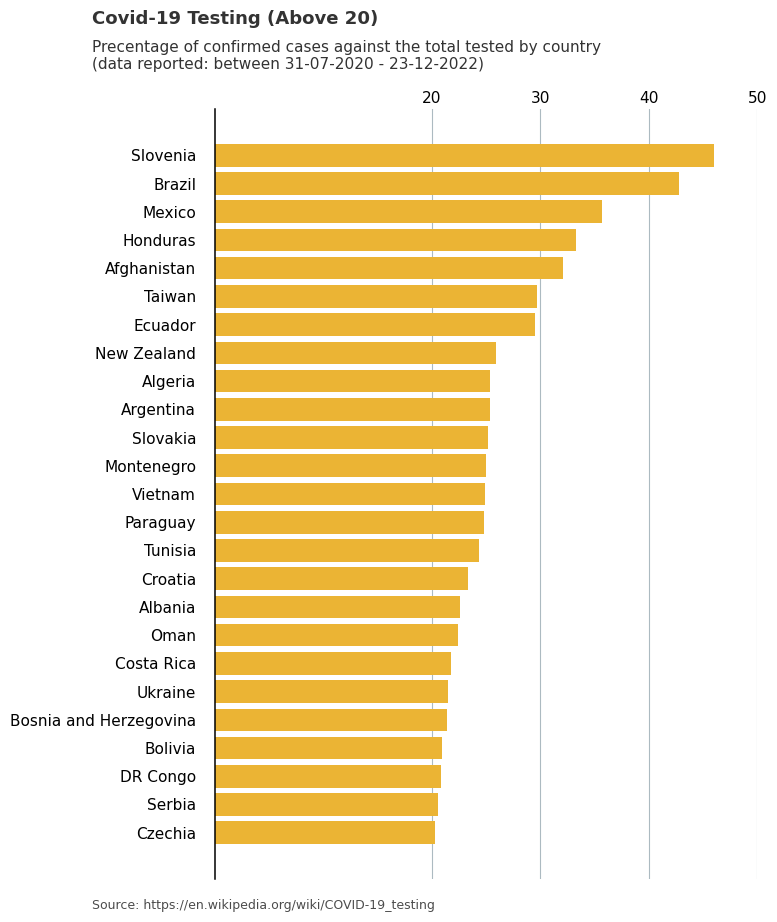

In [98]:
# Data vizualization with matplotlib
fig, ax = plt.subplots(figsize=(7,10))

ax.grid(which="major", axis='x', color='#758D99', alpha=0.6, zorder=1)
ax.spines[['top','right','bottom']].set_visible(False)
ax.spines['left'].set_linewidth(1.1)

ax.barh(subset['COUNTRY'], subset['CONFIRMED/TESTED(%)'], color='#EBB434', zorder=2)

ax.set_xticks([20, 30, 40, 50])
ax.set_xticklabels([20, 30, 40, 50])

ax.xaxis.set_tick_params(labeltop=True, labelbottom=False, bottom=False, labelsize=11, pad=-1)
ax.yaxis.set_tick_params(pad=10, labelsize=11, bottom=False)

ax.text(x=-.05, y=.965, s="Covid-19 Testing (Above 20)", transform=fig.transFigure, fontsize=13, weight='bold', alpha=.8)
ax.text(x=-.05, y=.92, s="""Precentage of confirmed cases against the total tested by country
(data reported: between 31-07-2020 - 23-12-2022)""", transform=fig.transFigure, fontsize=11, alpha=.8)
ax.text(x=-.05, y=.08, s="Source: https://en.wikipedia.org/wiki/COVID-19_testing", transform=fig.transFigure, ha='left', fontsize=9, alpha=.7);

In [99]:
subset2 =  covid19table[covid19table['CONFIRMED/POPULATION(%)'] >= 20].sort_values(by=['CONFIRMED/POPULATION(%)'], ascending=True)
subset2.head()

,COUNTRY,DATE,TESTED,CONFIRMED,CONFIRMED/TESTED(%),TESTED/POPULATION(%),CONFIRMED/POPULATION(%)
6,Argentina,2022-04-16,35716069,9060495,25.4,78.3,20.0
42,Dominica,2022-06-20,209803,14821,7.1,293.0,20.7
125,Panama,2022-12-17,7361620,1020961,13.9,176.0,24.4
166,Uruguay,2022-04-16,6089116,895592,14.7,175.0,25.8
32,Chile,2022-12-23,47538151,5001737,10.5,249.0,26.2


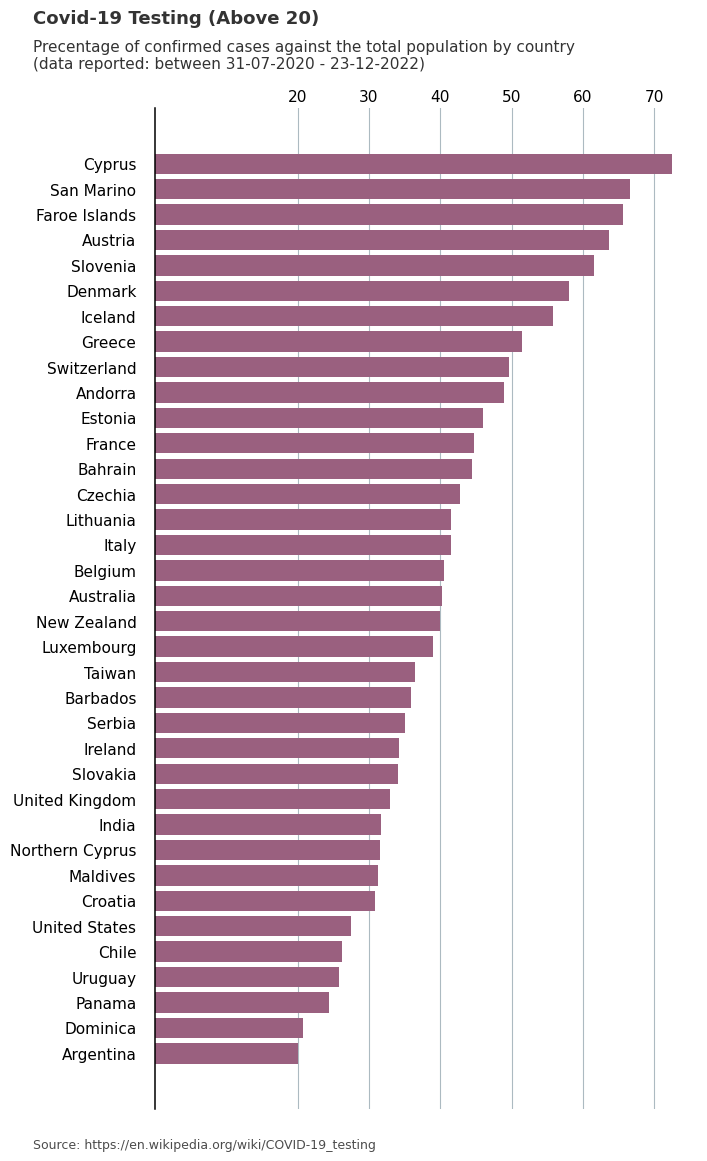

In [101]:
# Data vizualization with matplotlib
fig, ax = plt.subplots(figsize=(7,13))

ax.grid(which="major", axis='x', color='#758D99', alpha=0.6, zorder=1)
ax.spines[['top','right','bottom']].set_visible(False)
ax.spines['left'].set_linewidth(1.1)

ax.barh(subset2['COUNTRY'], subset2['CONFIRMED/POPULATION(%)'], color='#9A607F', zorder=2)

ax.set_xticks([20, 30, 40, 50, 60, 70])
ax.set_xticklabels([20, 30, 40, 50, 60, 70])

ax.xaxis.set_tick_params(labeltop=True, labelbottom=False, bottom=False, labelsize=11, pad=-1)
ax.yaxis.set_tick_params(pad=10, labelsize=11, bottom=False)

ax.text(x=-.05, y=.945, s="Covid-19 Testing (Above 20)", transform=fig.transFigure, ha='left', fontsize=13, weight='bold', alpha=.8)
ax.text(x=-.05, y=.91, s="""Precentage of confirmed cases against the total population by country
(data reported: between 31-07-2020 - 23-12-2022)""", transform=fig.transFigure, ha='left', fontsize=11, alpha=.8)
ax.text(x=-.05, y=.08, s="Source: https://en.wikipedia.org/wiki/COVID-19_testing", transform=fig.transFigure, ha='left', fontsize=9, alpha=.7);

In [102]:
response.close()

## Part 2. Web-scraping from Wikipedia: OECD average wages

In [103]:
url2 = "https://en.wikipedia.org/wiki/List_of_countries_by_average_wage"

In [104]:
session2 = requests.Session()
response2 = session2.get(url2, timeout = 10)

In [105]:
soup2 = BeautifulSoup(response2.text, 'html.parser')

In [106]:
table1 = soup2.find('table', {'class':"wikitable"})

In [107]:
table1 = pd.read_html(str(table1))
table2 = pd.DataFrame(table1[0])

In [108]:
table2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Country  35 non-null     object
 1   2000     35 non-null     int64 
 2   2005     35 non-null     int64 
 3   2010     35 non-null     int64 
 4   2011     35 non-null     int64 
 5   2012     35 non-null     int64 
 6   2013     35 non-null     int64 
 7   2014     35 non-null     int64 
 8   2015     35 non-null     int64 
 9   2016     35 non-null     int64 
 10  2017     35 non-null     int64 
 11  2018     35 non-null     int64 
 12  2019     35 non-null     int64 
 13  2020     35 non-null     int64 
dtypes: int64(13), object(1)
memory usage: 4.0+ KB


In [109]:
table2.head()

,Country,2000,2005,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,United States *,55366,58092,61048,61132,61634,61347,62263,63845,63942,64618,65303,66383,69392
1,Iceland *,53810,61187,51234,53452,53137,53966,54736,58377,62949,69051,72466,70391,67488
2,Luxembourg *,57100,59505,63917,62955,62451,63058,65379,66247,66393,67393,67448,66840,65854
3,Switzerland *,56529,61063,63277,63533,64582,65431,65548,65910,65453,65151,64963,65906,64824
4,Netherlands *,52371,54565,57959,57601,57835,58035,57729,58403,58604,58171,57581,57475,58828


In [110]:
# Removing special characters from the Country column
table2['Country'] = table2['Country'].str.replace('[*]', '', regex=True)
table2.head()

,Country,2000,2005,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,United States,55366,58092,61048,61132,61634,61347,62263,63845,63942,64618,65303,66383,69392
1,Iceland,53810,61187,51234,53452,53137,53966,54736,58377,62949,69051,72466,70391,67488
2,Luxembourg,57100,59505,63917,62955,62451,63058,65379,66247,66393,67393,67448,66840,65854
3,Switzerland,56529,61063,63277,63533,64582,65431,65548,65910,65453,65151,64963,65906,64824
4,Netherlands,52371,54565,57959,57601,57835,58035,57729,58403,58604,58171,57581,57475,58828


In [111]:
# Creating subset for visualization
table2_sub = table2[['Country','2000','2010','2020']].set_index('Country')
table2_sub.head()

,2000,2010,2020
Country,,,
United States,55366,61048,69392
Iceland,53810,51234,67488
Luxembourg,57100,63917,65854
Switzerland,56529,63277,64824
Netherlands,52371,57959,58828


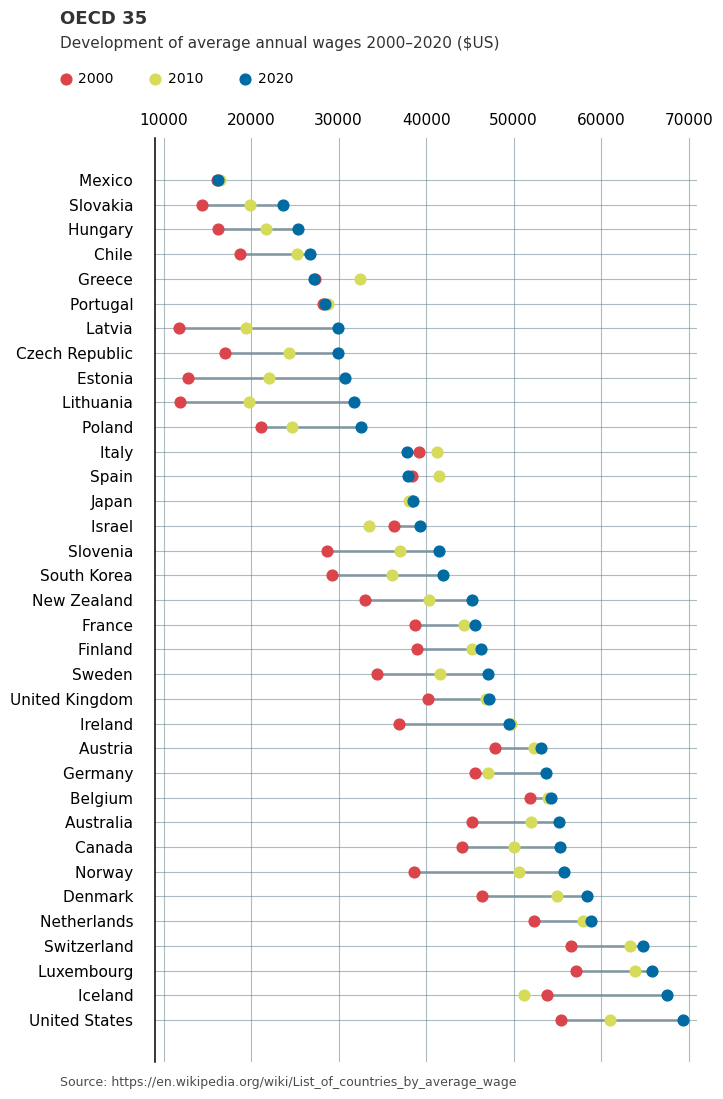

In [112]:
# Data vizualization with matplotlib
fig, ax = plt.subplots(figsize=(7,12))

ax.grid(which="major", axis='both', color='#758D99', alpha=0.6, zorder=1)
ax.spines[['top','right','bottom']].set_visible(False) 
ax.spines['left'].set_linewidth(1.1)

ax.hlines(y=table2_sub.index, xmin=table2_sub["2000"], xmax=table2_sub["2020"], color='#758D99', zorder=2, linewidth=2, label='_nolegend_', alpha=.8)
ax.scatter(table2_sub["2000"], table2_sub.index, s=60, color='#DB444B', zorder=3)
ax.scatter(table2_sub["2010"], table2_sub.index, s=60, color='#D7DB5A', zorder=3)
ax.scatter(table2_sub["2020"], table2_sub.index, s=60, color='#006BA2', zorder=3)
ax.set_xlim(9000, 71000)

ax.xaxis.set_tick_params(labeltop=True, labelbottom=False, bottom=False, labelsize=11)            
ax.yaxis.set_tick_params(pad=10, labelsize=11, bottom=False)

ax.legend(['2000', '2010', '2020'], loc=(-0.2, 1.05), ncol=3, frameon=False, handletextpad=-.1, handleheight=1)

ax.text(x = -0.01, y = 0.975, s = "OECD 35", transform = fig.transFigure, fontsize=13, weight='bold', alpha=.8)
ax.text(x = -0.01, y = 0.955, s = "Development of average annual wages 2000–2020 ($US)", transform=fig.transFigure, fontsize=11, alpha=.8)
ax.text(x = -0.01, y = 0.09, s = "Source: https://en.wikipedia.org/wiki/List_of_countries_by_average_wage", transform=fig.transFigure, fontsize=9, alpha=.7);

In [113]:
response2.close()

## Part 3. API: Nasdaq data link (Time-series data)

In this part I will collect data from Nasdaq data link (API) and procceed with showcasing my skills dealing with Time-series data, which includes resampling and data visuzalization.

In [114]:
quandl.ApiConfig.api_key = "sYxJvgY2_hH4JHJZ2R7p"

# Establishing time period
start = datetime.datetime(2012, 1, 1)
end = datetime.datetime(2017, 12, 31)

# Collecting data from Nasdaq data link
amzn = web.DataReader('WIKI/AMZN', 'quandl', start, end, api_key = "sYxJvgY2_hH4JHJZ2R7p")
fb = web.DataReader('WIKI/FB', 'quandl', start, end, api_key = "sYxJvgY2_hH4JHJZ2R7p")
ibm = web.DataReader('WIKI/IBM', 'quandl', start, end, api_key = "sYxJvgY2_hH4JHJZ2R7p")
mmm = web.DataReader('WIKI/MMM', 'quandl', start, end, api_key = "sYxJvgY2_hH4JHJZ2R7p")

In [115]:
# Selecting only adjusted closed price columns for plotting
amzn_adjclosed = amzn['AdjClose']
fb_adjclosed = fb['AdjClose']
ibm_adjclosed = ibm['AdjClose']
mmm_adjclosed = mmm['AdjClose']

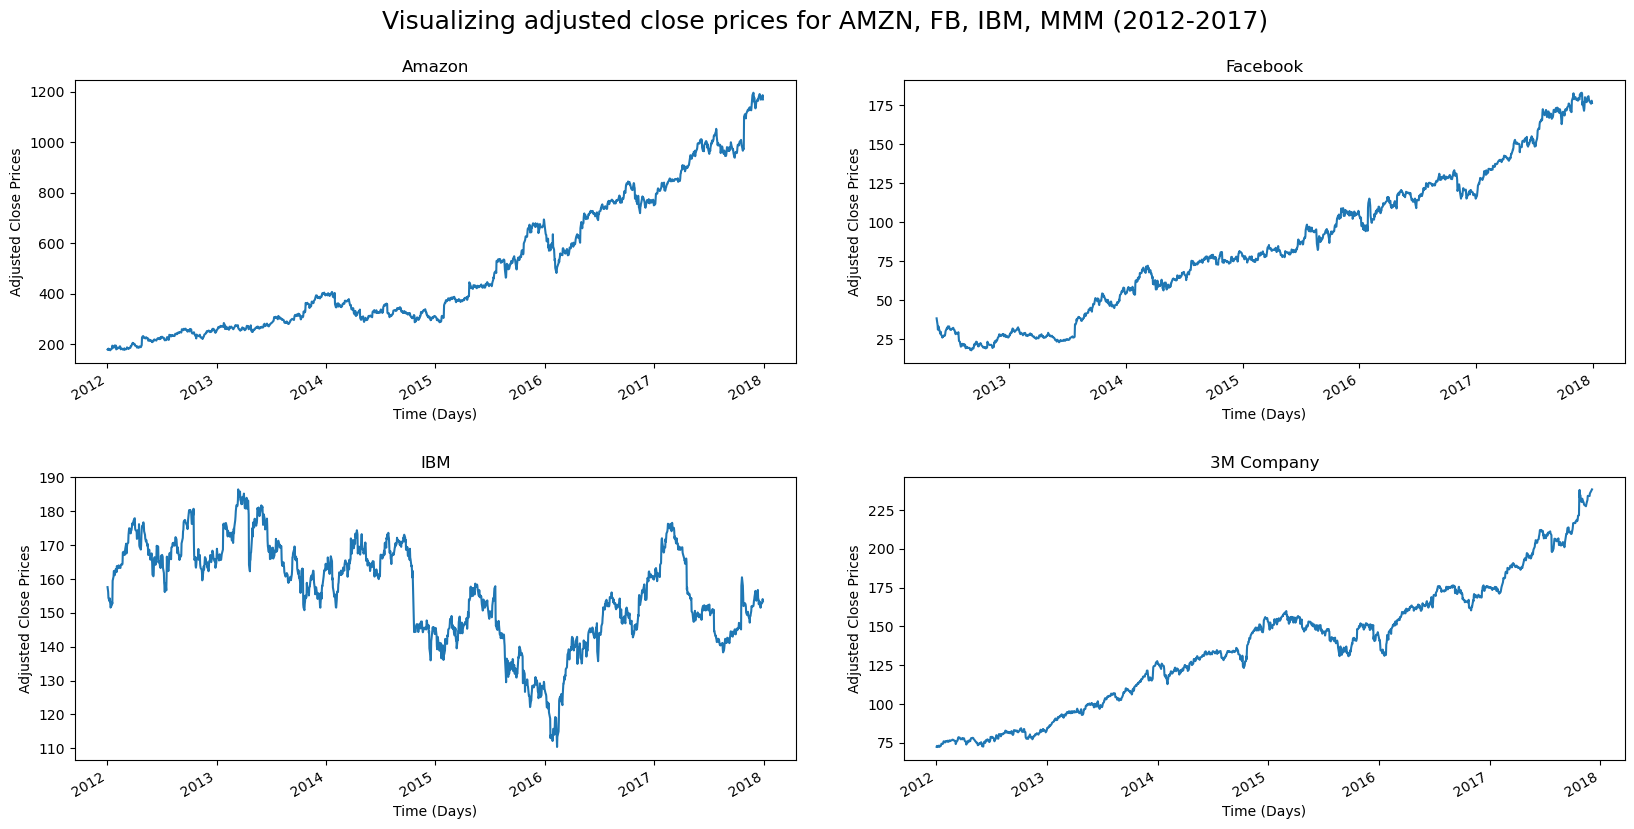

In [116]:
# Visualizing data
fig = plt.figure(figsize=(20, 10))
fig.suptitle('Visualizing adjusted close prices for AMZN, FB, IBM, MMM (2012-2017)', y = 0.95, fontsize=18)
fig.subplots_adjust(hspace=0.4, wspace=0.15)

plt.subplot(2,2,1)
plt.title('Amazon')
amzn = amzn_adjclosed.plot()
amzn.set_ylabel("Adjusted Close Prices")
amzn.set_xlabel("Time (Days)")


plt.subplot(2,2,2)
plt.title('Facebook')
fb = fb_adjclosed.plot()
fb.set_ylabel("Adjusted Close Prices")
fb.set_xlabel("Time (Days)")


plt.subplot(2,2,3)
plt.title('IBM')
ibm = ibm_adjclosed.plot()
ibm.set_ylabel("Adjusted Close Prices")
ibm.set_xlabel("Time (Days)")


plt.subplot(2,2,4)
plt.title('3M Company')
mmm = mmm_adjclosed.plot()
mmm.set_ylabel("Adjusted Close Prices")
mmm.set_xlabel("Time (Days)");

In [117]:
# Resampling time series data
amzn_endof_m = amzn_adjclosed.resample('BM').last()
fb_endof_m = fb_adjclosed.resample('BM').last()
ibm_endof_m = ibm_adjclosed.resample('BM').last()
mmm_endof_m = mmm_adjclosed.resample('BM').last()

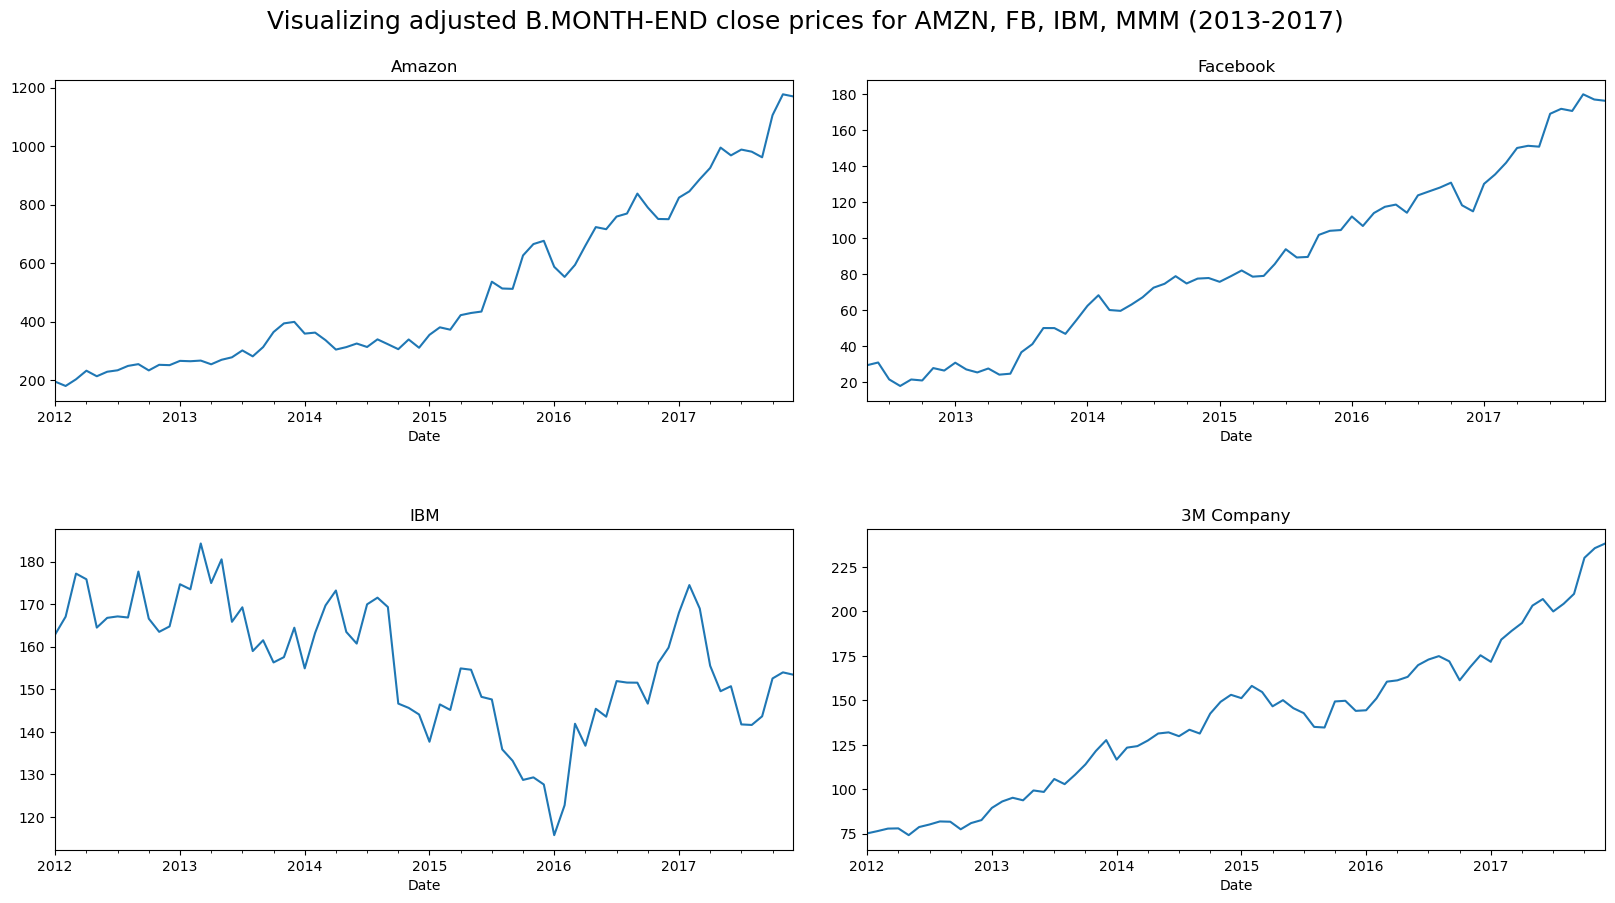

In [118]:
# Vizualizing resampled data
fig = plt.figure(figsize=(20, 10))
fig.suptitle('Visualizing adjusted B.MONTH-END close prices for AMZN, FB, IBM, MMM (2013-2017)', y = 0.95, fontsize=18)
fig.subplots_adjust(hspace=0.4, wspace=0.1)

plt.subplot(2,2,1)
amzn_endof_m.plot()
plt.title('Amazon')

plt.subplot(2,2,2)
fb_endof_m.plot()
plt.title('Facebook')

plt.subplot(2,2,3)
ibm_endof_m.plot()
plt.title('IBM')

plt.subplot(2,2,4)
mmm_endof_m.plot()
plt.title('3M Company');

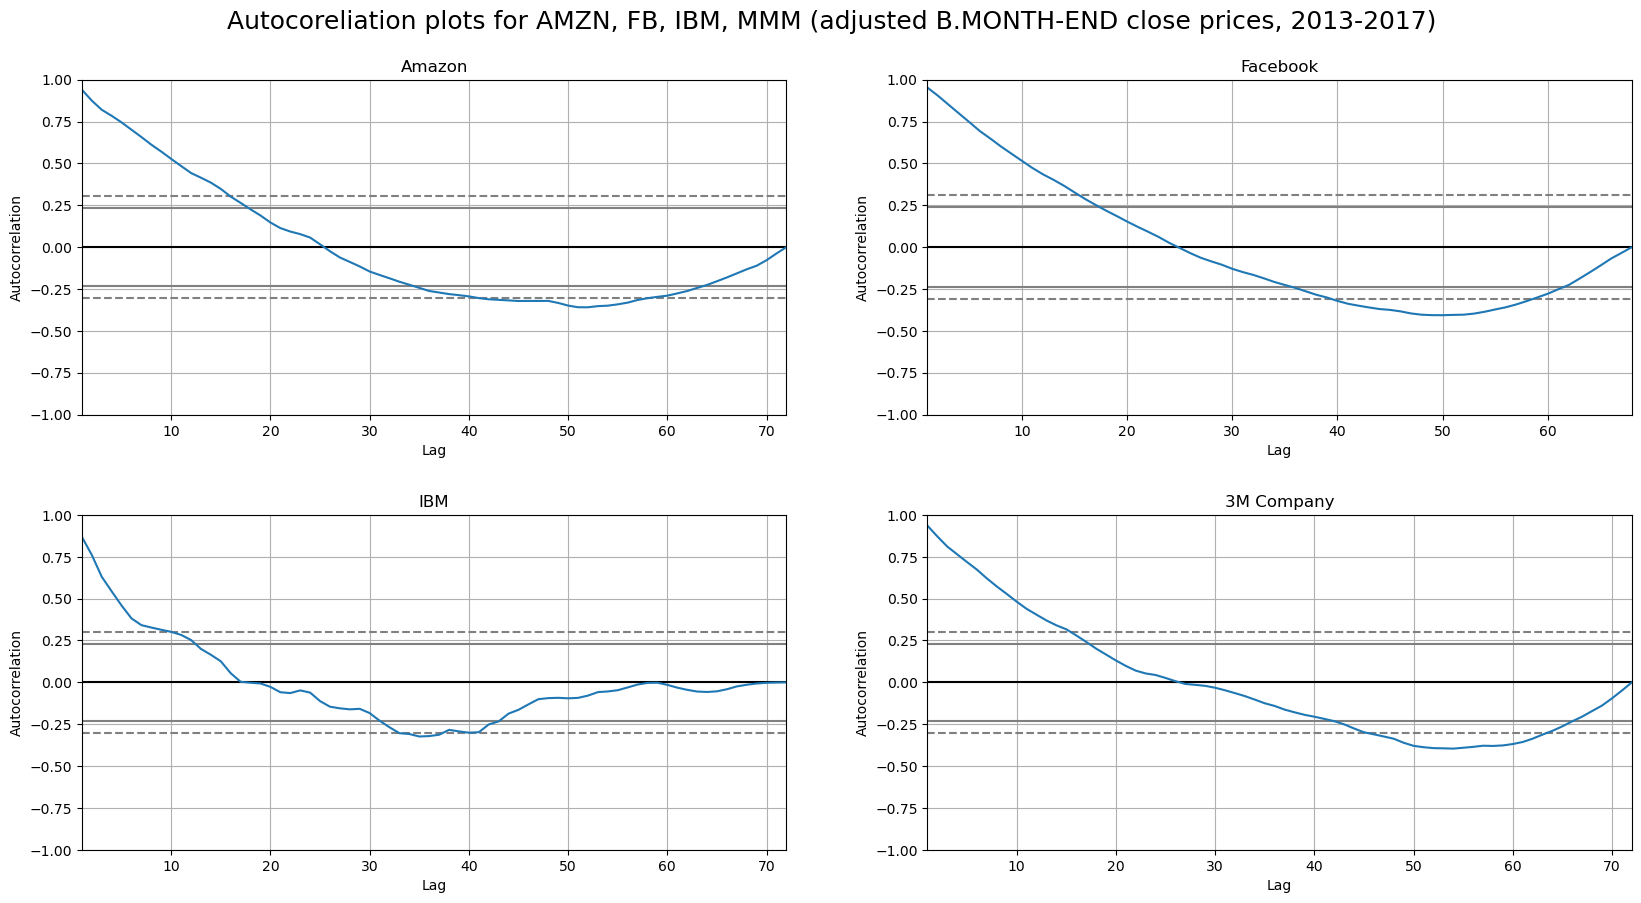

In [119]:
# Producing autocorelation plots
fig = plt.figure(figsize=(20, 10))
fig.suptitle('Autocoreliation plots for AMZN, FB, IBM, MMM (adjusted B.MONTH-END close prices, 2013-2017)', y = 0.95, fontsize=18)
fig.subplots_adjust(hspace=0.3, wspace=0.2)

plt.subplot(2,2,1)
pd.plotting.autocorrelation_plot(amzn_endof_m)
plt.title('Amazon')

plt.subplot(2,2,2)
pd.plotting.autocorrelation_plot(fb_endof_m)
plt.title('Facebook')

plt.subplot(2,2,3)
pd.plotting.autocorrelation_plot(ibm_endof_m)
plt.title('IBM')

plt.subplot(2,2,4)
pd.plotting.autocorrelation_plot(mmm_endof_m)
plt.title('3M Company');

**REMARKS:** In this example I have extracted stock data from Nasdaq data link (API) of 4 companies - Amazon, Facebook, IBM and 3M Company. After the data was collected I proceeded with data visualization, resampling and produced autocorrelation plots. The following conclusions can be drawn from this data: from the autocoreliation plots I can see that time and adjusted close prices are correlated, data is not white noise and is non-stationary. However, data is autocorelated for the first 10  to 12 months (IBM period is even shorter). It is clear that for all stocks with the increase of a lag period the data stabilizes and correlation between adjusted close price and time becomes less significant.